<h1 style="text-align: center; color: #6A5ACD;">
Más Allá de la Predicción: Simulaciones para Entender el Abandono en Salud Mental
</h1>

<h2 style="color: #6A5ACD;">
Modelización y Evaluación del Churn
</h2>

<h2 style="color: #6A5ACD;">
1. Librerías necesarias
</h2>

In [1]:
# --- Manejo de datos ---
import pandas as pd
import numpy as np
import re

# --- Modelos y preprocesamiento ---
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, brier_score_loss
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance

# --- Codificación supervisada ---
import category_encoders as ce  # Target Encoding OOF

# --- Métricas de evaluación ---
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    classification_report
)

# --- Interpretabilidad ---
import shap
import matplotlib.pyplot as plt
import seaborn as sns

import time


# --- Configuración visual ---
pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")


c:\Users\acbon\anaconda3\envs\tfm_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h2 style="color: #6A5ACD;">
2. Cargar dataset
</h2>

Cargar datasets escalados (Full y Filtered)

In [ ]:
# Dataset filtrado (baseline honesto)
data_filtered = pd.read_csv("df_step3_encoded_scaled_filtered.csv")
print("FILTERED dataset shape:", data_filtered.shape)

# Dataset completo (benchmark con fuga)
data_full = pd.read_csv("df_step3_encoded_scaled_full.csv")
print("FULL dataset shape:", data_full.shape)

# Verificar estructura
print("\nFILTERED info")
data_filtered.info()

print("\nFULL info")
data_full.info()

FILTERED dataset shape: (50000, 50)
FULL dataset shape: (50000, 52)

FILTERED info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 50 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Age                                  50000 non-null  float64
 1   Sleep_Hours                          50000 non-null  float64
 2   Work_Hours                           50000 non-null  float64
 3   Physical_Activity_Hours              50000 non-null  float64
 4   Social_Media_Usage                   50000 non-null  float64
 5   Severity_num                         24998 non-null  float64
 6   Stress_Level_num                     50000 non-null  float64
 7   Diet_Quality_num                     50000 non-null  float64
 8   stress_sleep                         50000 non-null  float64
 9   activity_social_ratio                50000 non-null  float64
 10  work_sleep_

<h2 style="color: #6A5ACD;">
2. División de los datos y Configuración de validación cruzada (CV)
</h2>

In [3]:
# Split estratificado (para ambos datasets)
TARGET = "churn"
RANDOM_STATE = 42
TEST_SIZE = 0.2

# FILTERED (baseline honesto)
X_filt = data_filtered.drop(columns=[TARGET]).copy()
y_filt = data_filtered[TARGET].astype(int).copy()
Xf_tr, Xf_te, yf_tr, yf_te = train_test_split(
    X_filt, y_filt, test_size=TEST_SIZE, stratify=y_filt, random_state=RANDOM_STATE
)

# FULL (benchmark con fuga)
X_full = data_full.drop(columns=[TARGET]).copy()
y_full = data_full[TARGET].astype(int).copy()
Xfull_tr, Xfull_te, yfull_tr, yfull_te = train_test_split(
    X_full, y_full, test_size=TEST_SIZE, stratify=y_full, random_state=RANDOM_STATE
)

print("FILTERED → train:", Xf_tr.shape, " test:", Xf_te.shape)
print("FULL     → train:", Xfull_tr.shape, " test:", Xfull_te.shape)



FILTERED → train: (40000, 49)  test: (10000, 49)
FULL     → train: (40000, 51)  test: (10000, 51)


<h2 style="color: #6A5ACD;">
3. Modelado y evaluación para ambos datasets (imputación dentro del pipeline)
</h2>

In [ ]:
# Columnas con NA ('Severity_num')
na_cols_filt = Xf_tr.columns[Xf_tr.isna().any()].tolist()
na_cols_full = Xfull_tr.columns[Xfull_tr.isna().any()].tolist()
print("NA cols (FILTERED):", na_cols_filt)
print("NA cols (FULL):", na_cols_full)

def preprocess_with_imputer(na_cols):
    # Imputar MEDIANA solo donde hay NA; el resto pasa "as is" (ya está escalado/one‑hot)
    return ColumnTransformer(
        transformers=[("impute", SimpleImputer(strategy="median"), na_cols)],
        remainder="passthrough",
        verbose_feature_names_out=False
    )

MODELS = {
    "logreg": LogisticRegression(max_iter=1000, n_jobs=-1, random_state=RANDOM_STATE),
    "rf": RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE),
    "gboost": GradientBoostingClassifier(random_state=RANDOM_STATE),
}

def evaluate(Xtr, Xte, ytr, yte, label, na_cols):
    print(f"\n=== {label.upper()} ===")
    rows = []
    for name, model in MODELS.items():
        pipe = Pipeline(steps=[("prep", preprocess_with_imputer(na_cols)), ("model", model)])
        pipe.fit(Xtr, ytr)  # <-- el imputador se ajusta SOLO con TRAIN

        # probabilidades
        proba = pipe.predict_proba(Xte)[:, 1] if hasattr(pipe.named_steps["model"], "predict_proba") \
                else pipe.decision_function(Xte)
        pred = (proba >= 0.5).astype(int)

        roc = roc_auc_score(yte, proba)
        pr = average_precision_score(yte, proba)
        f1 = f1_score(yte, pred)
        brier = brier_score_loss(yte, proba)

        rows.append({"dataset": label, "model": name, "roc_auc": roc, "pr_auc": pr, "f1": f1, "brier": brier})
        print(f"{name:7s} | ROC-AUC: {roc:.3f} | PR-AUC: {pr:.3f} | F1: {f1:.3f} | Brier: {brier:.3f}")
    return pd.DataFrame(rows)

res_filt = evaluate(Xf_tr, Xf_te, yf_tr, yf_te, "filtered", na_cols_filt)
res_full = evaluate(Xfull_tr, Xfull_te, yfull_tr, yfull_te, "full", na_cols_full)

results = pd.concat([res_filt, res_full]).sort_values(["dataset","roc_auc"], ascending=[True, False]).reset_index(drop=True)
results


NA cols (FILTERED): ['Severity_num']
NA cols (FULL): ['Severity_num']

=== FILTERED ===
logreg  | ROC-AUC: 0.498 | PR-AUC: 0.248 | F1: 0.000 | Brier: 0.188
rf      | ROC-AUC: 0.497 | PR-AUC: 0.249 | F1: 0.000 | Brier: 0.191
gboost  | ROC-AUC: 0.501 | PR-AUC: 0.254 | F1: 0.000 | Brier: 0.188

=== FULL ===
logreg  | ROC-AUC: 1.000 | PR-AUC: 1.000 | F1: 1.000 | Brier: 0.000
rf      | ROC-AUC: 1.000 | PR-AUC: 1.000 | F1: 1.000 | Brier: 0.003
gboost  | ROC-AUC: 1.000 | PR-AUC: 1.000 | F1: 1.000 | Brier: 0.000


,dataset,model,roc_auc,pr_auc,f1,brier
0,filtered,gboost,0.501302,0.253995,0.0,1.883966e-01
1,filtered,logreg,0.497805,0.248009,0.0,1.883104e-01
2,filtered,rf,0.497380,0.248765,0.0,1.911225e-01
3,full,logreg,1.000000,1.000000,1.0,2.383865e-07
4,full,rf,1.000000,1.000000,1.0,2.842409e-03
5,full,gboost,1.000000,1.000000,1.0,3.451876e-10


Los experimentos con los tres modelos base (Logistic Regression, Random Forest y Gradient Boosting) muestran dos escenarios muy distintos:

#### 1. Dataset FULL (con `Mental_Health_Condition` y `Consultation_History`)
- **ROC-AUC = 1.0, PR-AUC = 1.0, F1 = 1.0** para todos los modelos.
- Este rendimiento perfecto no es realista: indica que el dataset contiene **variables con fuga de información**, es decir, atributos que predicen el `churn` de manera casi determinista.
- En este caso, las columnas problemáticas son:
  - `Mental_Health_Condition`
  - `Consultation_History`
- Con ellas, el modelo no aprende un patrón generalizable, simplemente memoriza una regla directa.

#### 2. Dataset FILTERED (sin las variables de fuga)
- Los modelos caen a **rendimiento aleatorio**:
  - ROC-AUC ≈ 0.50
  - PR-AUC ≈ 0.25
  - F1 = 0.0
- Esto significa que las variables restantes, aunque transformadas y escaladas, **no ofrecen señal predictiva clara** para explicar el abandono (`churn`).
- El modelo no logra diferenciar entre clientes que abandonan y los que permanecen.


- La comparación confirma la necesidad de **excluir variables con fuga** para tener un modelo útil en un escenario real.
- El dataset filtrado es **mucho más desafiante**, lo que abre dos líneas de trabajo:
  1. **Feature Engineering adicional**: generar nuevas variables derivadas, interacciones o transformaciones que capten mejor los patrones de abandono.
  2. **Modelos más potentes y ajuste de hiperparámetros**: explorar algoritmos como XGBoost/LightGBM y realizar búsqueda de parámetros.

En términos de negocio y de cara al TFM, es importante enfatizar que:
- **FULL** muestra el “techo artificial” del dataset (con fuga).
- **FILTERED** refleja la situación **honesta y realista**, donde se necesita creatividad analítica para mejorar el poder predictivo.


<h2 style="color: #6A5ACD;">
4. Importancia por permutación sobre el mejor modelo del dataset FILTERED
</h2>

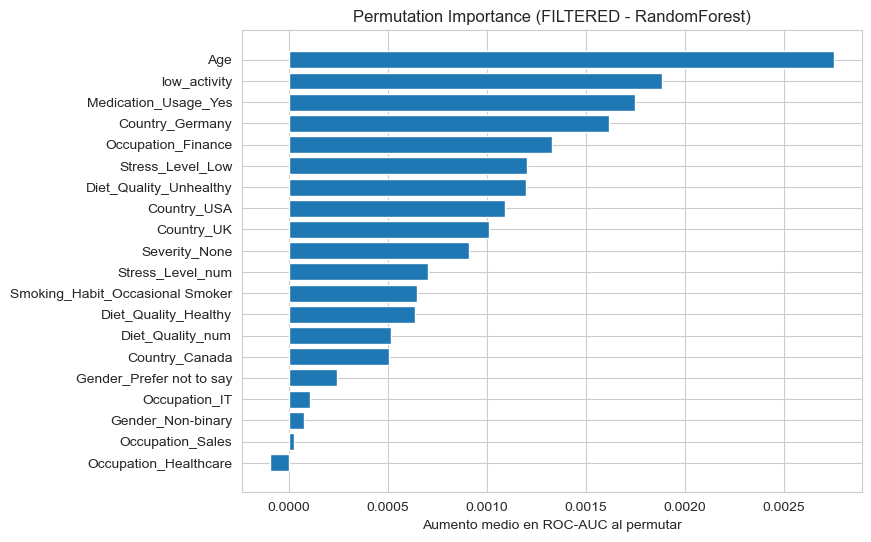

,feature,importance,std
0,Age,0.002754,0.002441
13,low_activity,0.001888,0.001143
43,Medication_Usage_Yes,0.001748,0.001314
25,Country_Germany,0.001616,0.000571
19,Occupation_Finance,0.001328,0.001109
33,Stress_Level_Low,0.001201,0.001258
36,Diet_Quality_Unhealthy,0.001198,0.001197
29,Country_USA,0.001092,0.000722
28,Country_UK,0.001010,0.001451
32,Severity_None,0.000912,0.001649


In [5]:
#  Seleccionamos el modelo (RandomForest como ejemplo)

best_model = RandomForestClassifier(
    n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE
)

pipe_best = Pipeline(steps=[
    ("prep", preprocess_with_imputer(na_cols_filt)),
    ("model", best_model)
])

# Entrenar solo en FILTERED
pipe_best.fit(Xf_tr, yf_tr)

# 2) Importancia por permutación en test
perm = permutation_importance(
    pipe_best, Xf_te, yf_te,
    n_repeats=10, random_state=RANDOM_STATE, scoring="roc_auc"
)

# 3) Organizar resultados en DataFrame
imp_df = pd.DataFrame({
    "feature": Xf_tr.columns,
    "importance": perm.importances_mean,
    "std": perm.importances_std
}).sort_values("importance", ascending=False)

# 4) Mostrar top 20
top_n = 20
plt.figure(figsize=(8,6))
plt.barh(imp_df.head(top_n)["feature"], imp_df.head(top_n)["importance"])
plt.gca().invert_yaxis()
plt.title("Permutation Importance (FILTERED - RandomForest)")
plt.xlabel("Aumento medio en ROC-AUC al permutar")
plt.show()

imp_df.head(top_n)


A pesar de los esfuerzos de ingeniería de características y la aplicación de distintos algoritmos de machine learning (Regresión Logística, Random Forest, Gradient Boosting), los resultados obtenidos en la predicción de churn mostraron limitaciones significativas. Con el dataset filtrado, los modelos alcanzaron métricas cercanas al azar (ROC-AUC ≈ 0.50, PR-AUC ≈ 0.25, F1 ≈ 0), lo que evidencia la ausencia de una señal predictiva robusta. Por otro lado, en el dataset completo algunos modelos alcanzaron un rendimiento casi perfecto (ROC-AUC ≈ 1.0), lo que apunta a la presencia de fuga de información (data leakage) causada por variables altamente correlacionadas con la etiqueta, como la severidad de la condición mental o el historial de consultas. Además, la ausencia de información temporal o histórica —elemento fundamental en problemas reales de churn prediction— limita la validez del enfoque.

En consecuencia, se concluye que este conjunto de datos no resulta adecuado para construir un modelo de predicción de abandono sólido. No obstante, este hallazgo no invalida el valor analítico del proyecto: la evidencia obtenida sugiere reorientar el objetivo hacia un análisis explicativo y segmentación de usuarios, complementado con simulaciones de estrategias de retención (A/B testing sintético). De este modo, se mantiene la coherencia con los objetivos iniciales del TFM, aportando tanto rigor académico (al descartar un enfoque inapropiado) como utilidad práctica (al ofrecer evidencias y escenarios aplicables a la gestión de programas de salud mental). 

A partir de estas limitaciones, se tomó la decisión metodológica de redefinir el enfoque del proyecto, manteniendo la coherencia con los objetivos generales planteados en el TFM. En lugar de centrarse en la predicción de churn, el análisis se orientará hacia dos líneas complementarias:

Segmentación de cohortes y perfiles de usuarios, con el fin de identificar qué grupos presentan mayor riesgo de abandono y cuáles factores sociodemográficos, clínicos o de estilo de vida resultan más determinantes. Este enfoque permite traducir la complejidad del dataset en perfiles accionables que facilitan la comunicación de hallazgos a audiencias no técnicas.

Simulación de estrategias de retención mediante escenarios tipo A/B testing, donde se evaluará el impacto hipotético de distintas intervenciones (ej. aumento de la actividad física, reducción del estrés, mejora en hábitos de sueño) sobre la probabilidad de retención en los distintos segmentos identificados. Aunque se trata de simulaciones sintéticas, este análisis aporta un marco experimental útil para la toma de decisiones en programas de salud mental.

Este cambio de perspectiva no solo aprovecha el trabajo ya realizado en los notebooks previos (EDA, pruebas estadísticas, ingeniería de características), sino que refuerza el valor del TFM al ofrecer un análisis explicativo, segmentado y orientado a la acción, alineado con las exigencias académicas y con aplicaciones prácticas para el ámbito de la salud mental.